<a href="https://colab.research.google.com/github/yuhao831068/Vgg11_for_Classify_CCTV_with_Gun_appearance/blob/main/Vgg11_sr_non-resize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch

In [3]:
import torchvision

In [36]:
# import model
import torchvision.models as models
model = models.vgg11_bn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
# import weights and set transformer
import torchvision.transforms as transforms
weights = models.VGG11_BN_Weights.DEFAULT
vgg11_bn_transforms = weights.transforms()

In [6]:
vgg11_bn_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [7]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
# see the architecture of the model
summary = summary(model=model,
        input_size=(8,3,448,448),
        col_names=['input_size','output_size','num_params','trainable'],
        row_settings=['var_names'])

In [38]:
num_features = model.classifier[6].in_features
num_features

4096

In [39]:
# set the model to 2-classes-classifier
import torch.nn as nn
model.classifier[6] = nn.Linear(num_features, 2)

In [ ]:
summary

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
VGG (VGG)                                [8, 3, 448, 448]          [8, 2]                    --                        Partial
├─Sequential (features)                  [8, 3, 448, 448]          [8, 512, 14, 14]          --                        False
│    └─Conv2d (0)                        [8, 3, 448, 448]          [8, 64, 448, 448]         (1,792)                   False
│    └─BatchNorm2d (1)                   [8, 64, 448, 448]         [8, 64, 448, 448]         (128)                     False
│    └─ReLU (2)                          [8, 64, 448, 448]         [8, 64, 448, 448]         --                        --
│    └─MaxPool2d (3)                     [8, 64, 448, 448]         [8, 64, 224, 224]         --                        --
│    └─Conv2d (4)                        [8, 64, 224, 224]         [8, 128, 224, 224]        (73,856)                  False


In [40]:
# set the layers untrainable except final layer
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[6].parameters():
    param.requires_grad = True

In [ ]:
summary

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
VGG (VGG)                                [8, 3, 448, 448]          [8, 2]                    --                        Partial
├─Sequential (features)                  [8, 3, 448, 448]          [8, 512, 14, 14]          --                        False
│    └─Conv2d (0)                        [8, 3, 448, 448]          [8, 64, 448, 448]         (1,792)                   False
│    └─BatchNorm2d (1)                   [8, 64, 448, 448]         [8, 64, 448, 448]         (128)                     False
│    └─ReLU (2)                          [8, 64, 448, 448]         [8, 64, 448, 448]         --                        --
│    └─MaxPool2d (3)                     [8, 64, 448, 448]         [8, 64, 224, 224]         --                        --
│    └─Conv2d (4)                        [8, 64, 224, 224]         [8, 128, 224, 224]        (73,856)                  False


In [41]:
# define dataset
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image

class ImageDataset(Dataset):
  def __init__(self, root, train, transform=None):
    if train:
      image_root = Path(root) / 'train'
    else:
      image_root = Path(root) / 'test'

    # filter DS.Store
    self.paths = [i for i in image_root.rglob('*') if i.is_file() and i.name != '.DS_Store']
    self.transform = transform


    with open(Path(root) / 'classnames.txt','r') as f:
      lines = f.readlines()
      classes = []
      for line in lines:
        stripped_line = line.strip()
        classes.append(stripped_line)
        self.classes = classes

  def __getitem__(self, index):
    img = Image.open(self.paths[index]).convert('RGB')
    class_name = self.paths[index].parent.name
    class_idx = self.classes.index(class_name)

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

  def __len__(self):
    return len(self.paths)

In [42]:
# set dataset

train_dataset = ImageDataset(root='/content/drive/MyDrive/final dataset-sr',
             train=True,
             transform=vgg11_bn_transforms)

test_dataset = ImageDataset(root='/content/drive/MyDrive/final dataset-sr',
             train=False,
             transform=vgg11_bn_transforms)

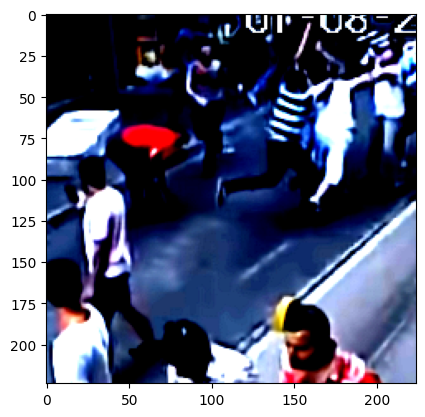

In [43]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[0][0].permute(1, 2, 0))

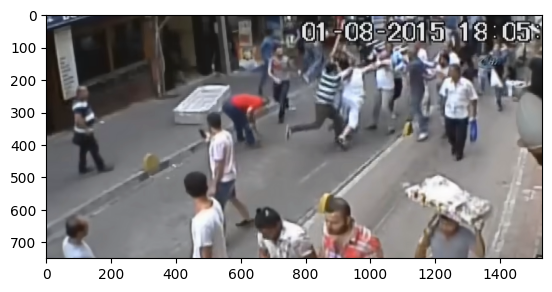

In [44]:
import matplotlib.pyplot as plt
from PIL import Image

# Get the path to the first image in the training dataset
image_path = train_dataset.paths[0]

# Open and display the image
plt.imshow(Image.open(image_path))

In [ ]:
train_dataset[0]

(tensor([[[ 0.8276,  0.7933,  0.7077,  ..., -1.5699, -1.6213, -1.6555],
          [ 0.7933,  0.8104,  0.7762,  ..., -1.5185, -1.6213, -1.6898],
          [ 0.8276,  0.8961,  0.8618,  ..., -1.5357, -1.6213, -1.6384],
          ...,
          [-0.7993, -0.6109, -0.5424,  ...,  1.3584,  0.2624, -1.0733],
          [-0.8678, -0.6794, -0.5596,  ...,  1.1529,  0.9646, -0.9020],
          [-0.8335, -0.7479, -0.5938,  ...,  0.7933,  1.1015, -0.1143]],
 
         [[ 0.7479,  0.7129,  0.6429,  ..., -1.0203, -1.0903, -1.1604],
          [ 0.7129,  0.7479,  0.7129,  ..., -0.9853, -1.0903, -1.1954],
          [ 0.7304,  0.8179,  0.8004,  ..., -1.0028, -1.0903, -1.1429],
          ...,
          [-0.7402, -0.5651, -0.4951,  ...,  1.0455, -0.1800, -1.7556],
          [-0.8102, -0.6176, -0.4951,  ...,  0.8704,  0.5903, -1.4930],
          [-0.7752, -0.6877, -0.5301,  ...,  0.5028,  0.7654, -0.6527]],
 
         [[ 1.5071,  1.4374,  1.3502,  ..., -0.0267, -0.0790, -0.1661],
          [ 1.4722,  1.4722,

In [45]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = False)

In [46]:
def train_step(dataloader, model, cost_fn, optimizer, device):

  train_cost = 0
  train_acc = 0

  for batch, (x, y) in enumerate(dataloader):
    x = x.to(device)
    y = y.to(device )

    model.train()

    y_pred = model(x)

    cost = cost_fn(y_pred, y)
    train_cost += cost
    train_acc += (y_pred.argmax(dim=1)==y).sum() / len(y) * 100

    optimizer.zero_grad()

    cost.backward()

    optimizer.step()


  train_cost /= len(dataloader)
  train_acc /= len(dataloader)
  print(f'Train Cost: {train_cost:.4f}, Train Acc:{train_acc:.2f}')

def test_step(dataloader, model, cost_fn, device):

  test_cost = 0
  test_acc = 0
  model.eval()
  with torch.inference_mode():
    for x, y in dataloader:
      x = x.to(device)
      y = y.to(device )

      test_pred = model(x)
      test_cost +=  cost_fn(test_pred, y)
      test_acc += (test_pred.argmax(dim=1)==y).sum() / len(y) * 100

    test_cost /= len(dataloader)
    test_acc /= len(dataloader)
    print(f'Test Cost:{test_cost:.4f}, Test Acc:{test_acc:.2f}')

In [47]:
# set cost function and optimizer

cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [49]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [50]:
from tqdm.auto import tqdm

epochs = 20 #把資料看完20次
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n-------')

  train_step(train_dataloader, model, cost_fn, optimizer, device)
  test_step(test_dataloader, model, cost_fn, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
-------
Train Cost: 0.6943, Train Acc:57.25
Test Cost:0.7194, Test Acc:54.46
Epoch: 1
-------
Train Cost: 0.5452, Train Acc:71.00
Test Cost:0.7170, Test Acc:54.46
Epoch: 2
-------
Train Cost: 0.5227, Train Acc:73.00
Test Cost:0.7078, Test Acc:54.46
Epoch: 3
-------
Train Cost: 0.4976, Train Acc:76.00
Test Cost:0.8347, Test Acc:55.36
Epoch: 4
-------
Train Cost: 0.4620, Train Acc:78.25
Test Cost:0.7622, Test Acc:52.68
Epoch: 5
-------
Train Cost: 0.4473, Train Acc:80.50
Test Cost:0.7686, Test Acc:58.93
Epoch: 6
-------
Train Cost: 0.4183, Train Acc:80.50
Test Cost:0.8074, Test Acc:55.36
Epoch: 7
-------
Train Cost: 0.4144, Train Acc:82.75
Test Cost:0.8230, Test Acc:54.46
Epoch: 8
-------
Train Cost: 0.4211, Train Acc:81.00
Test Cost:0.8391, Test Acc:57.14
Epoch: 9
-------
Train Cost: 0.4044, Train Acc:82.00
Test Cost:0.8937, Test Acc:58.04
Epoch: 10
-------
Train Cost: 0.3930, Train Acc:84.25
Test Cost:0.8522, Test Acc:57.14
Epoch: 11
-------
Train Cost: 0.3911, Train Acc:81.25